In [196]:
#Importieren der Plugins
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

In [197]:
'''Daten einlesen'''

'Daten einlesen'

In [198]:
ratings = pd.read_csv('ratings100k.csv')

In [199]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [200]:
"""
Um etwas Zugriff zu bekommen, werden User und Filme rausgeschmissen, die zu wenig Bewertungen bekommen.
Inhaltlich passt dies auch, da diese Nutzer zuerst auf anderem Wege (Cold Start) Vorschläge erhalten
"""
f = ['count','mean']

df_movie_summary = ratings.groupby('movieId')['rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = ratings.groupby('userId')['rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 7.0
Customer minimum times of review: 140.0


In [201]:
print('Original Shape: {}'.format(ratings.shape))
ratings = ratings[~ratings['movieId'].isin(drop_movie_list)]
ratings = ratings[~ratings['userId'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(ratings.shape))

Original Shape: (100836, 4)
After Trim Shape: (63950, 4)


In [202]:
'''Pre-Processing'''

'Pre-Processing'

In [203]:
movies_raw = pd.read_csv('movies100k.csv')
tmdb_raw = pd.read_csv('tmdb.csv')
df = pd.merge(ratings, movies_raw, on='movieId')
df = pd.merge(tmdb_raw,df, on='movieId')
#Erscheinungsjahr extrahieren
year = df[['movieId','title']].groupby(['movieId','title']).first().reset_index()
year['year'] = year['title'].str.extract(r'\((\d+)\)\s*$')
year = year.drop('title',axis=1)
year = year.set_index('movieId')
#year[pd.isnull(year.year).sort_values(ascending=False)] #Ausnahmen
#year.fillna(1900).astype(int).hist() #Probleme mit NaN Values, ohne Plotten
year = year.fillna(1900).astype(int)
df = pd.merge(df,year,on='movieId')

In [204]:
df = df.dropna()

In [205]:
df = df[df['cast'] !=0]

In [206]:
df.head()

,movieId,cast,director,overview,userId,rating,timestamp,title,genres,year
0,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",7,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",18,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
3,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",19,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
4,1,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...",John Lasseter,"Led by Woody, Andy's toys live happily in his ...",21,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995


In [207]:
'''Splitten der Genres'''

'Splitten der Genres'

In [208]:
genres = df.genres.str.split("|",expand=True,)

In [209]:
genres = genres[[0,1,2]]
genres = genres.rename(columns={0: "Genre1", 1: "Genre2", 2: "Genre3"})
genres

,Genre1,Genre2,Genre3
0,Adventure,Animation,Children
1,Adventure,Animation,Children
2,Adventure,Animation,Children
3,Adventure,Animation,Children
4,Adventure,Animation,Children
...,...,...,...
63945,Action,Comedy,Sci-Fi
63946,Action,Comedy,Sci-Fi
63947,Action,Comedy,Sci-Fi
63948,Action,Comedy,Sci-Fi


In [210]:
'''Splitten vom Cast'''

'Splitten vom Cast'

In [211]:
cast = df.cast.str.split(",",expand=True,)

In [212]:
cast = cast[[0,1,2]]
cast = cast.rename(columns={0: "Cast1", 1: "Cast2", 2: "Cast3"})
cast

,Cast1,Cast2,Cast3
0,Tom Hanks,Tim Allen,Don Rickles
1,Tom Hanks,Tim Allen,Don Rickles
2,Tom Hanks,Tim Allen,Don Rickles
3,Tom Hanks,Tim Allen,Don Rickles
4,Tom Hanks,Tim Allen,Don Rickles
...,...,...,...
63945,Adam Driver,Jonathan Pryce,Stellan Skarsgård
63946,Adam Driver,Jonathan Pryce,Stellan Skarsgård
63947,Adam Driver,Jonathan Pryce,Stellan Skarsgård
63948,Adam Driver,Jonathan Pryce,Stellan Skarsgård


In [213]:
'''Features wählen'''

'Features wählen'

In [214]:
cast1_25 = cast.Cast1.value_counts().head(25)
cast2_25 = cast.Cast2.value_counts().head(25)
cast3_25 = cast.Cast3.value_counts().head(25)
director25 = df.director.value_counts().head(25)
genre1_25 = genres.Genre1.value_counts().head(5)

In [215]:
#Top Schauspieler
cast1_25

Tom Hanks                726
Mel Gibson               507
John Cusack              453
Kevin Costner            444
Harrison Ford            436
Robert De Niro           420
Clint Eastwood           413
Jim Carrey               385
Arnold Schwarzenegger    381
Robin Williams           376
Adam Sandler             367
John Travolta            364
Sylvester Stallone       361
Tom Cruise               355
Jackie Chan              350
Woody Allen              345
Brad Pitt                318
Sandra Bullock           313
Johnny Depp              309
Mark Hamill              304
Matthew Broderick        302
Al Pacino                301
Sean Connery             296
Bill Murray              278
Richard Gere             276
Name: Cast1, dtype: int64

In [216]:
#Top Regisseure
director25

Steven Spielberg        516
Woody Allen             370
Martin Scorsese         348
Terry Gilliam           346
Robert Zemeckis         342
James Cameron           335
Sam Raimi               330
Clint Eastwood          304
Oliver Stone            301
Stanley Kubrick         298
Ron Howard              273
Ridley Scott            268
Francis Ford Coppola    266
John McTiernan          262
Luc Besson              261
Brian De Palma          256
Jonathan Demme          247
Richard Donner          247
John Huston             237
Jan de Bont             236
Alfred Hitchcock        230
Tim Burton              229
Roland Emmerich         218
Chuck Russell           215
Tony Scott              210
Name: director, dtype: int64

In [217]:
#Abdeckung ausrechnen
print((sum(cast1_25)/cast.index.size) * 100)
print((sum(cast2_25)/cast.index.size) * 100)
print((sum(cast3_25)/cast.index.size) * 100)
print((sum(director25)/df.index.size) * 100)
print((sum(genre1_25)/cast.index.size) * 100)

14.81621886303685
8.351103318643478
6.897913408836026
11.285915114754616
90.33470754553065


In [218]:
#Top Genres
genre1_25

Action       20425
Comedy       15982
Drama         9744
Adventure     6871
Crime         4168
Name: Genre1, dtype: int64

In [219]:
#Nur die Top 25 berücksichtigen
cast.Cast1[~cast.Cast1.isin(cast1_25.index)] = 0
cast.Cast2[~cast.Cast2.isin(cast2_25.index)] = 0
cast.Cast3[~cast.Cast3.isin(cast3_25.index)] = 0
df.director[~df.director.isin(director25.index)] = 0


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [220]:
'''Zusammensetzung von Allem in ein Dataframe'''

'Zusammensetzung von Allem in ein Dataframe'

In [221]:
#Zusammensetzen aller Dataframes
df = pd.concat([df, cast, genres], axis=1)

In [222]:
df = df[['director', 'rating', 'year', 'Cast1', 'Cast2', 'Cast3', 'Genre1', 'Genre2', 'Genre3']]

In [223]:
#One Hot Encoding
directors = pd.get_dummies(df.director, prefix='director')
casts1 = pd.get_dummies(df.Cast1, prefix='Cast1')
casts2 = pd.get_dummies(df.Cast1, prefix='Cast2')
casts3 = pd.get_dummies(df.Cast1, prefix='Cast3')
genres1 = pd.get_dummies(df.Genre1, prefix='Genre1')
genres2 = pd.get_dummies(df.Genre2, prefix='Genre2')
genres3 =pd.get_dummies(df.Genre3, prefix='Genre3')

In [224]:
df = pd.concat([df, casts1, casts2, casts3, genres1, genres2, genres2, directors], axis=1)

In [225]:
df = df.drop(columns=['Cast1', 'Cast2', 'Cast3', 'Genre1', 'Genre2', 'Genre3', 'director'])

In [226]:
ratings = df

In [227]:
#komplett quantifizierbares Dataframe
ratings = ratings.reset_index(drop=False)
ratings['year'] = ratings['year']/ratings['year'].max()
ratings.head()

,index,rating,year,Cast1_0,Cast1_Adam Sandler,Cast1_Al Pacino,Cast1_Arnold Schwarzenegger,Cast1_Bill Murray,Cast1_Brad Pitt,Cast1_Clint Eastwood,...,director_Robert Zemeckis,director_Roland Emmerich,director_Ron Howard,director_Sam Raimi,director_Stanley Kubrick,director_Steven Spielberg,director_Terry Gilliam,director_Tim Burton,director_Tony Scott,director_Woody Allen
0,0,4.0,0.988603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4.5,0.988603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3.5,0.988603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4.0,0.988603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3.5,0.988603,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
'''Aufbau des NN'''

'Aufbau des NN'

In [229]:
#Aufteilung in Trainings- und Testdaten
X = ratings.drop('rating', axis=1).values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [230]:
#Zusammenbau des Neuronalen Netzes
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(in_features=160, out_features=100, bias = True)
        self.fc3 = nn.Dropout(p=0.2)
        self.fc4 = nn.ReLU()
        self.fc5 = nn.Linear(in_features=100, out_features=200, bias = True)
        self.fc6 = nn.ReLU()
        self.fc7 = nn.Dropout(p=0.2)
        self.fc8 = nn.Linear(in_features=200, out_features=300, bias = True)
        self.fc9 = nn.Dropout(p=0.2)
        self.output = nn.Linear(in_features=300, out_features=6, bias = True)
 
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = F.tanh(self.fc5(x))
        x = F.tanh(self.fc6(x))
        x = F.tanh(self.fc7(x))
        x = F.tanh(self.fc8(x))
        x = F.tanh(self.fc9(x))
        x = self.output(x)
        return x

In [231]:
model = ANN()

model = ANN()
model

In [232]:
%%time
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001, amsgrad=False)



epochs = 100
loss_arr = []

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
    
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 1.7913823127746582
Epoch: 10 Loss: 1.4808242321014404
Epoch: 20 Loss: 1.4432506561279297
Epoch: 30 Loss: 1.4371082782745361
Epoch: 40 Loss: 1.4339860677719116
Epoch: 50 Loss: 1.4288549423217773
Epoch: 60 Loss: 1.4226922988891602
Epoch: 70 Loss: 1.4168620109558105
Epoch: 80 Loss: 1.414130449295044
Epoch: 90 Loss: 1.4124014377593994
CPU times: user 2min 32s, sys: 39.5 s, total: 3min 12s
Wall time: 1min 42s


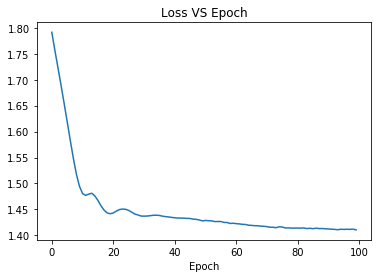

In [233]:
plt.title('Loss VS Epoch')
plt.xlabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)

In [234]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())

In [235]:
'''Datenanalyse'''

'Datenanalyse'

In [236]:
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]
df['diff'] = np.abs(df.Y - df.YHat) 

In [237]:
#keine Guten Ergebnisse
print(df.Y.mean())
print(df.YHat.mean())
print(df.YHat.min())
print(df.YHat.max())

3.352034369471822
3.501137225170584
3
5


In [238]:
df.head(100)

,Y,YHat,Correct,diff
0,3,4,0,1
1,4,3,0,1
2,4,4,1,0
3,4,4,1,0
4,2,4,0,2
...,...,...,...,...
95,5,3,0,2
96,3,3,1,0
97,4,4,1,0
98,2,3,0,1


In [239]:
#Accuracy
df['Correct'].sum() / len(df)

0.3787591609805408

In [240]:
#Mae ausrechnen
mae = df['diff'].mean()
mae

0.7954258276472075